# Pokemons dataset
### It has some stats of pocemons, according to pokemon lore. We'll predict Legendarity. <br>
Name = name<br>
Type 1 = main type of pokemon<br>
Type 2 = additional type of pokemon<br>
Total = sum of all numerical stats<br>
HP = health points<br>
Attack = attack power<br>
Defense = defense power<br>
Sp. Atk = special attack ability power<br>
Sp. Def = special defensive ability power<br>
Speed = speed (mean both move speed and attack speed, i guess)<br>
Generation = generation (some feature in pokemon selection)<br>
Legndary = the rare-indicator feature (~8% samples have it)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')

### We should change True -> 1 and False -> 0 as not every model support boolean

In [2]:
pok = pd.read_csv('Pokemon.csv')
pok.drop('#', axis=1, inplace=True)
pok.Legendary = pok.Legendary.apply(lambda x: 1 if x else 0)
pok.head()

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,0
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,0
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,0
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,0
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,0


### Let's have a look at some distribution in every numeric features for each legendary and non-legendary pokemons
(False is blue one)

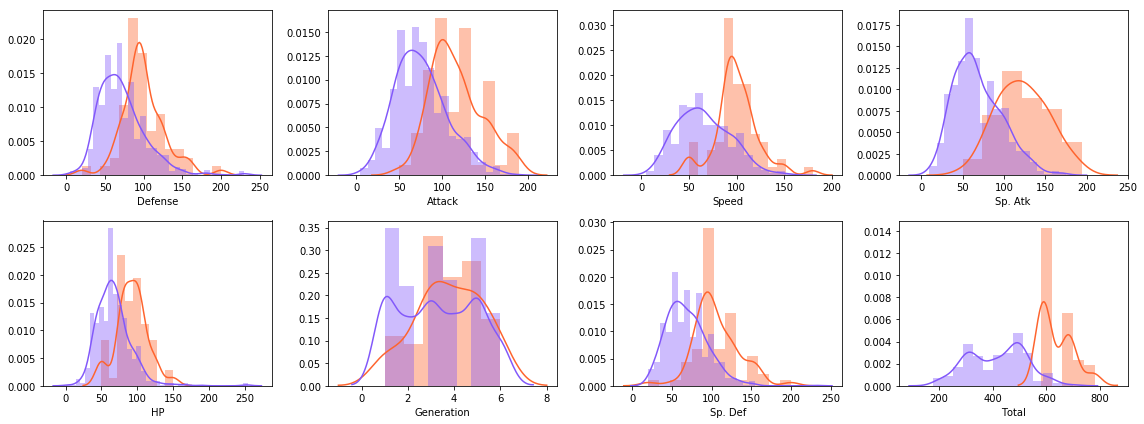

In [3]:
fig, ax = plt.subplots(2,4, figsize=(16,6))
ax = ax.flatten()
i = 0
for feature in set(pok.columns) - set(('Legendary', 'Name', 'Type 1', 'Type 2')):
    sb.distplot(pok[(pok.Legendary == True)][feature], ax=ax[i], label=feature, color='#fe642e')
    sb.distplot(pok[(pok.Legendary == False)][feature], ax=ax[i], color='#8258fa')
    i += 1
fig.tight_layout()

# sb.distplot(pok[(pok.Legendary == True)], ax=ax[0,1])

As we can see, there are some features, which can help us with future prediction of Legendarity
### Now let's check that with a special built-in tool

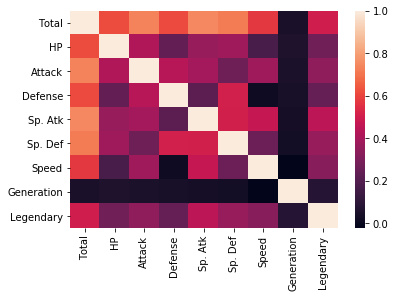

In [4]:
sb.heatmap(pok.corr())

Now we found a very noizy feature, that won\'t allow us predict our target properly. Of course we can drop it, but the fact is that .corr() show us only linear dependance of numeric values, and 'generation' is a categorical 
feature, so I'd prefer to let it in peace
### And let's try one more plot

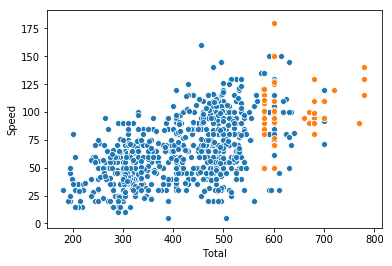

In [5]:
sb.scatterplot(x=pok[(pok.Legendary == False)]['Total'], y=pok[(pok.Legendary == False)]['Speed'])
sb.scatterplot(x=pok[(pok.Legendary == True)]['Total'], y=pok[(pok.Legendary == True)]['Speed'])

Here we can see, that our features are a bit discrete, so mb any tree-based models will deal the best 
### Now let's see if there are some outlier data

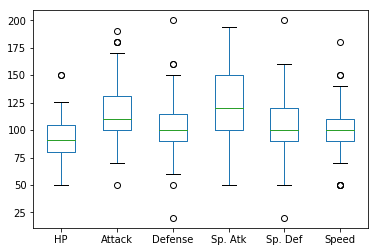

In [6]:
pok[(pok.Legendary == True)][['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].plot.box()

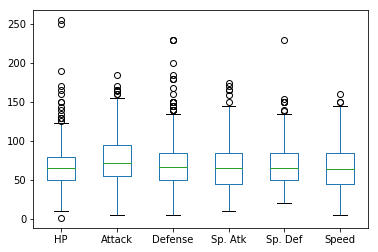

In [7]:
pok[(pok.Legendary == False)][['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].plot.box()

Yes, we have some non-common values, so let's remember that and use RobusScaler for removing them from our train dataset
### Time for models
Let's chose accuracy as a score and some models, to see, which one will work better

In [8]:
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import f1_score as f1
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold

/home/abyzs/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [9]:
pok.fillna('None')
pok = pok.join(pd.get_dummies(pok[['Type 1', 'Type 2']]))
pok.drop(['Type 1', 'Type 2', 'Name'], axis=1, inplace=True)
pok.fillna(0)
pok_trn = pok.drop('Legendary', axis=1)
pok_val = pok['Legendary']
pok.head()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Type 1_Bug,...,Type 2_Ghost,Type 2_Grass,Type 2_Ground,Type 2_Ice,Type 2_Normal,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water
0,318,45,49,49,65,65,45,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,405,60,62,63,80,80,60,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,525,80,82,83,100,100,80,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,625,80,100,123,122,120,80,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,309,39,52,43,60,50,65,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
models = [
    RF(n_jobs=-1, n_estimators=200, random_state=42),
    LR(max_iter=200, random_state=42, solver='liblinear'),
    LR(max_iter=200, random_state=42, solver='lbfgs'),
    MLP(random_state=42, max_iter=200)
]
models_names = [
    'RandomForest',
    'LogisticRegressionLinear',
    'LogisticRegressionLbfgs',
    'MLPClassifier'
]

rezults_acc = []
rezults_f1 = []

In [11]:
splitter = KFold(n_splits=5, shuffle=True, random_state=42)
rezult_acc = {'preprocessing': 'None'}
rezult_f = {'preprocessing': 'None'}
for i in range(len(models)):
    m = models[i]
    name = models_names[i]
    acc = []
    f = []
    for trn, val in splitter.split(pok):
        m.fit(pok_trn.iloc[trn,:], pok_val[trn])
        prediction = m.predict(pok_trn.iloc[val,:])
        acc.append(accuracy(pok_val[val], prediction))
        f.append(f1(pok_val[val], prediction))
    print(f'{name} has {sum(acc) / len(acc)*100:.2f}% accuracy and {sum(f) / len(f)*100:.2f}% f1-score')
    rezult_acc[name] = np.round(sum(acc) / len(acc)*100, 2)
    rezult_f[name] = np.round(sum(f) / len(f)*100, 2)
rezults_acc.append(rezult_acc)
rezults_f1.append(rezult_f)

RandomForest has 95.12% accuracy and 64.55% f1-score
LogisticRegressionLinear has 92.88% accuracy and 32.98% f1-score
LogisticRegressionLbfgs has 93.62% accuracy and 56.43% f1-score
MLPClassifier has 88.63% accuracy and 4.40% f1-score


We can see, that RandomForest is a leader<br>
Now let's have some work with outliers and classweights

In [12]:
splitter = KFold(n_splits=5, shuffle=True, random_state=42)
rs = RobustScaler(with_centering=False, with_scaling=False, quantile_range=(25.0, 75.0))
rezult_acc = {'preprocessing': 'Outliers'}
rezult_f = {'preprocessing': 'Outliers'}
for i in range(len(models)):
    m = models[i]
    name = models_names[i]
    acc = []
    f = []
    for trn, val in splitter.split(pok):
        m.fit(rs.fit_transform(pok_trn.iloc[trn,:]), pok_val[trn])
        prediction = m.predict(rs.transform(pok_trn.iloc[val,:]))
        acc.append(accuracy(pok_val[val], prediction))
        f.append(f1(pok_val[val], prediction))
    print(f'{name} has {sum(acc) / len(acc)*100:.2f}% accuracy and {sum(f) / len(f)*100:.2f}% f1-score')
    rezult_acc[name] = np.round(sum(acc) / len(acc)*100, 2)
    rezult_f[name] = np.round(sum(f) / len(f)*100, 2)
rezults_acc.append(rezult_acc)
rezults_f1.append(rezult_f)

RandomForest has 95.12% accuracy and 64.55% f1-score
LogisticRegressionLinear has 92.88% accuracy and 32.98% f1-score
LogisticRegressionLbfgs has 93.62% accuracy and 56.43% f1-score
MLPClassifier has 88.63% accuracy and 4.40% f1-score


Looks like outliers not the real problem in this dataset, but let's do the same, but with scaling and centering

In [13]:
splitter = KFold(n_splits=5, shuffle=True, random_state=42)
rs = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))
rezult_acc = {'preprocessing': 'Outliers, scalling'}
rezult_f = {'preprocessing': 'Outliers, scalling'}
for i in range(len(models)):
    m = models[i]
    name = models_names[i]
    acc = []
    f = []
    for trn, val in splitter.split(pok):
        m.fit(rs.fit_transform(pok_trn.iloc[trn,:]), pok_val[trn])
        prediction = m.predict(rs.transform(pok_trn.iloc[val,:]))
        acc.append(accuracy(pok_val[val], prediction))
        f.append(f1(pok_val[val], prediction))
    print(f'{name} has {sum(acc) / len(acc)*100:.2f}% accuracy and {sum(f) / len(f)*100:.2f}% f1-score')
    rezult_acc[name] = np.round(sum(acc) / len(acc)*100, 2)
    rezult_f[name] = np.round(sum(f) / len(f)*100, 2)
rezults_acc.append(rezult_acc)
rezults_f1.append(rezult_f)

RandomForest has 95.12% accuracy and 64.55% f1-score
LogisticRegressionLinear has 94.50% accuracy and 60.86% f1-score
LogisticRegressionLbfgs has 94.50% accuracy and 62.47% f1-score
MLPClassifier has 94.75% accuracy and 65.62% f1-score


That looks pretty good. Almost every model has score upgraid. Going forward - now time for class weights. First way is to pick as many samples as has the lesser class

In [14]:
def balance(df, target):
    positive = len(df[df[target] == 1])
    negative = len(df[df[target] == 0])
    maks_rows = min(positive, negative)
    a = df[df[target] == 1].sample(frac=1)
    a = a.index.values[:maks_rows]
    b = df[df[target] == 0].sample(frac=1)
    b = b.index.values[:maks_rows]
    return np.concatenate([a,b])



splitter = KFold(n_splits=5, shuffle=True, random_state=42)
rs = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))
rezult_acc = {'preprocessing': 'Outliers, scalling, min weight'}
rezult_f = {'preprocessing': 'Outliers, scalling, min weight'}
for i in range(len(models)):
    m = models[i]
    name = models_names[i]
    acc = []
    f = []
    for trn, val in splitter.split(pok):
        trn = balance(pok.iloc[trn,:], 'Legendary')
        m.fit(rs.fit_transform(pok_trn.iloc[trn,:]), pok_val[trn])
        prediction = m.predict(rs.transform(pok_trn.iloc[val,:]))
        acc.append(accuracy(pok_val[val], prediction))
        f.append(f1(pok_val[val], prediction))
    print(f'{name} has {sum(acc) / len(acc)*100:.2f}% accuracy and {sum(f) / len(f)*100:.2f}% f1-score')
    rezult_acc[name] = np.round(sum(acc) / len(acc)*100, 2)
    rezult_f[name] = np.round(sum(f) / len(f)*100, 2)
rezults_acc.append(rezult_acc)
rezults_f1.append(rezult_f)

RandomForest has 94.25% accuracy and 73.78% f1-score
LogisticRegressionLinear has 91.88% accuracy and 65.72% f1-score
LogisticRegressionLbfgs has 91.50% accuracy and 65.65% f1-score
MLPClassifier has 89.25% accuracy and 59.92% f1-score


And again we see score raising (except MLPClassifier). But let's see if there any different ways we can deal with unbalanced data. Let's pick as many samples as has bigger class

In [15]:
def balance(df, target):
    positive = len(df[df[target] == 1])
    negative = len(df[df[target] == 0])
    maks_rows = max(negative, positive)
    min_rows = min(negative, positive)
    max_target = np.argmax([negative, positive])
    min_target = np.argmin([negative, positive])
    # we'll duplicate every sample in small class 'scaller' times
    scaler = maks_rows // min_rows
    
    a = df[df[target] == max_target].sample(frac=1)
    a = a.index.values[:scaler * min_rows]
    
    b = df[df[target] == min_target].sample(frac=1)
    b = b.index.values[:min_rows]
    b = np.repeat(b, scaler)
    
    return np.concatenate([a, b])



splitter = KFold(n_splits=5, shuffle=True, random_state=42)
rs = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))
rezult_acc = {'preprocessing': 'Outliers, scalling, max weight'}
rezult_f = {'preprocessing': 'Outliers, scalling, max weight'}
for i in range(len(models)):
    m = models[i]
    name = models_names[i]
    acc = []
    f = []
    for trn, val in splitter.split(pok):
        trn = balance(pok.iloc[trn, :], 'Legendary')
        m.fit(rs.fit_transform(pok_trn.iloc[trn,:]), pok_val[trn])
        prediction = m.predict(rs.transform(pok_trn.iloc[val,:]))
        acc.append(accuracy(pok_val[val], prediction))
        f.append(f1(pok_val[val], prediction))
    print(f'{name} has {sum(acc) / len(acc)*100:.2f}% accuracy and {sum(f) / len(f)*100:.2f}% f1-score')
    rezult_acc[name] = np.round(sum(acc) / len(acc)*100, 2)
    rezult_f[name] = np.round(sum(f) / len(f)*100, 2)
rezults_acc.append(rezult_acc)
rezults_f1.append(rezult_f)

RandomForest has 95.62% accuracy and 74.02% f1-score
LogisticRegressionLinear has 93.50% accuracy and 70.09% f1-score
LogisticRegressionLbfgs has 93.75% accuracy and 71.02% f1-score
MLPClassifier has 95.12% accuracy and 71.87% f1-score


As we can see this method works better. It can be explained as we has very small positive class (8%)
### Now let's have a look at a table with all rezults

In [16]:
pd.DataFrame(rezults_acc)

,LogisticRegressionLbfgs,LogisticRegressionLinear,MLPClassifier,RandomForest,preprocessing
0,93.62,92.88,88.63,95.12,None
1,93.62,92.88,88.63,95.12,Outliers
2,94.50,94.50,94.75,95.12,"Outliers, scalling"
3,91.50,91.88,89.25,94.25,"Outliers, scalling, min weight"
4,93.75,93.50,95.12,95.62,"Outliers, scalling, max weight"


In [17]:
pd.DataFrame(rezults_f1)

,LogisticRegressionLbfgs,LogisticRegressionLinear,MLPClassifier,RandomForest,preprocessing
0,56.43,32.98,4.40,64.55,None
1,56.43,32.98,4.40,64.55,Outliers
2,62.47,60.86,65.62,64.55,"Outliers, scalling"
3,65.65,65.72,59.92,73.78,"Outliers, scalling, min weight"
4,71.02,70.09,71.87,74.02,"Outliers, scalling, max weight"


This table show us, that doesn't even matter which metric did you choose for yor ml problem. Almoust every time you should somehow clean your train data to improve rezult